In [2]:
# Standard Library Imports
import os                       # Operating system functions
import subprocess               # Subprocess management
import random                   # Random number generation
from tqdm import tqdm           # Progress bars

# Data Manipulation and Visualization
import json                     # JSON data manipulation
import inspect                  # Inspection of live objects
import pandas as pd              # Data manipulation using DataFrames
import numpy as np               # Numerical operations
import matplotlib.pyplot as plt  # Plotting
import seaborn as sns            # Styling plots

# Image Processing
from PIL import Image            # Python Imaging Library for image processing

# Model Libraries
import timm                     # Used for pre-trained models such as EfficientNet, ViT

# PyTorch
import torch                    # PyTorch overall import
import torch.optim as optim     # Optimization of model parameters
import torch.nn as nn           # Specification of neural networks
from torch.utils.data import Dataset, DataLoader  # Data loading utilities
import torchvision.transforms as transforms      # Pre-processing data

c:\Users\Public\anaconda3\envs\SFAI\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
class Config:
    _visualize_data = False

    # Reproducibility
    SEED = 42

    # Model Hyperparameters
    epochs = 10
    model_name = 'vit_large_patch16_224'                 # 'restnet_152', 'efficientnet_{b0, b1, ... , b7}', 'vit_base_path16_224', 'vit_large_patch16_224'
    _in_channels = 3                   # RGB images
    image_res = 64                     # Must be multiple of 256
    num_classes = 200
    use_pretrained_model = True
    # if model_name != 'vit' and model_name != 'resnet152' and int(model_name.split('_b')[-1]) >= 5:
    #     pretrained_efficient_net = False
    batch_size = 128                   # change batch size to fit memory budget, set to 2 here for contrastive loss
    learning_rate = 1e-5               # 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7
    dropout_rate = 0                   # 0, 0.1, 0.2, 0.3, 0.4, 0.5
    l2_regularization_strength = 0     # 0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7
    use_data_aug = False

    # Loss
    use_contrastive = False
    lambda_contrastive = 10            # 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7

    # Data Paths
    _data_path = os.path.join(os.getcwd(), 'data')
    dataset = 'tiny-imagenet-200'
    _ds_path = os.path.join(_data_path, dataset)
    _data_csv_path = os.path.join(_ds_path, 'tinyimagenet.csv')

    # Saving Paths
    _result_dir = "results"
    _weight_dir = "weights"
    if not os.path.exists(_result_dir):
        os.makedirs(_result_dir)
    if not os.path.exists(_weight_dir):
        os.makedirs(_weight_dir)
    
    # File Names and Paths
    _model_fname = f"best_{model_name}_lr-{learning_rate}_dropout-{dropout_rate}_dataAug-{use_data_aug}"
    _save_result_path = os.path.join(_result_dir, _model_fname)
    _save_weight_path = os.path.join(_weight_dir, f'{_model_fname}.pth')
    _dict = {}

config = Config()

In [4]:
class CustomViT(nn.Module):
    def __init__(self, cfg):
        super(CustomViT, self).__init__()
        self.model = timm.create_model(config.model_name, pretrained=config.use_pretrained_model, **cfg)

    def forward(self, x):
        return self.model(x)

In [11]:
custom_cfg = {
# 'img_size': config.image_res,
'img_size': config.image_res,
'patch_size': 16,               # default 16
'in_chans': config._in_channels,
'num_classes': config.num_classes,
'drop_rate': 0.1,
'pos_drop_rate': 0.01,
'attn_drop_rate': 0.01,
# Add other configuration options as needed
}
model = CustomViT(cfg=custom_cfg)

In [8]:
print(model)

CustomViT(
  (model): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1024, out_features=3072, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=1024, out_features=1024, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (act): GELU(approximate='no

In [9]:
print(len(model.blocks))

AttributeError: 'CustomViT' object has no attribute 'blocks'

In [32]:
def lr_time_based_decay(epoch, lr):
        return lr * 1 / (1 + 0.1 * epoch)
def lr_exp_decay(epoch):
    k = 0.1
    return config.learning_rate * np.exp(-k*epoch)

9.048374180359596e-06
8.18730753077982e-06
7.408182206817179e-06
6.703200460356394e-06
6.065306597126334e-06
5.488116360940264e-06
4.965853037914095e-06
4.493289641172216e-06
4.0656965974059915e-06
3.6787944117144236e-06


(0.0, 1e-05)

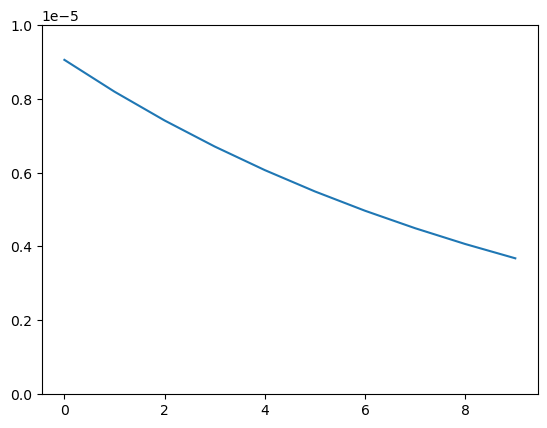

In [33]:
lrs = []
for i in range(10):
    lr = lr_exp_decay(i + 1)
    lrs.append(lr)
    print(lr)
plt.plot(range(10), lrs)
plt.ylim(0, 1e-5)